In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error,r2_score
import lightgbm as lgb

In [5]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))


In [6]:
dataset=(transactions
 .merge(items.drop(columns="item_name"),how="left")
 .assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+2013).astype(int))
 .drop(columns="date")

)

# Backfilling 

In [7]:
#If a shop has never sold X, it won't sell it in test

In [8]:
test_combis=test.assign(shop_item=lambda x: x.shop_id.astype(str)+"-"+x.item_id.astype(str)).shop_item

In [9]:
train_combis=transactions.groupby(["shop_id","item_id"]).count().reset_index().assign(shop_item=lambda x: x.shop_id.astype(str)+"-"+x.item_id.astype(str)).shop_item

In [10]:
test_combis=set(test_combis)

In [11]:
train_combis=set(train_combis)

In [12]:
#Combinations never seen before
len(test_combis-train_combis)

102796

In [13]:
#Items never seen before
test_items=set(test.item_id)
train_items=set(transactions.item_id)
display(len(test_items-train_items))
display(len(train_items))

363

21807

In [14]:
#Shops never seen before
test_shops=set(test.shop_id)
train_shops=set(transactions.shop_id)
display(len(test_shops-train_shops))
display(len(train_shops))

0

60

Items can be mean-encoded by taking their mean and std, some products are highly variable. And then, within each shop, we will also include the same features

## Encoding of prices

In [15]:
item_price=dataset.query("year>2013").groupby("item_id").item_price.agg(["mean","median","max"]).fillna(0)
item_price.columns=["mean_by_item","median_by_item","max_by_item"]
item_price.reset_index(inplace=True)
item_price.head(2)

,item_id,mean_by_item,median_by_item,max_by_item
0,0,58.000,58.000,58.000
1,1,4490.000,4490.000,4490.000


In [16]:
shop_price=dataset.query("year>2013").groupby(["item_id","shop_id"]).item_price.agg(["mean","std","median","max"]).fillna(0).reset_index()
shop_price.rename(columns={"mean":"mean_by_shop","std":"std_by_shop",
                           "median":"median_by_shop","max":"max_by_shop"},inplace=True)
shop_price.head(2)

,item_id,shop_id,mean_by_shop,std_by_shop,median_by_shop,max_by_shop
0,0,54,58.000,0.000,58.000,58.000
1,1,55,4490.000,0.000,4490.000,4490.000


In [17]:
item_price_cat=dataset.query("year>2013").groupby("item_category_id").item_price.agg(["mean","std","max","min"]).fillna(0)
item_price_cat.columns=["mean_by_item_cat","std_by_item_cat","max_by_item_cat","min_by_item_cat"]
item_price_cat.reset_index(inplace=True)
item_price_cat.head(2)

,item_category_id,mean_by_item_cat,std_by_item_cat,max_by_item_cat,min_by_item_cat
0,2,2410.482,1129.737,6090.000,148.000
1,3,2296.795,1452.959,7490.000,122.590


In [18]:
shop_price_cat=dataset.query("year>2013").groupby(["item_category_id","shop_id"]).item_price.agg(["mean"]).fillna(0).reset_index()
shop_price_cat.rename(columns={"mean":"mean_by_shop_cat"},inplace=True)
shop_price_cat.head(2)

,item_category_id,shop_id,mean_by_shop_cat
0,2,2,2369.329
1,2,3,2331.891


# Encoding of items sold

In [19]:
item_sold=(dataset.query("year>2013").groupby(["item_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby("item_id").item_cnt_day.agg(["mean","std","median","max"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold","std":"std_sold","median":"median_sold","max":"max_sold"})
)
item_sold.head(2)

,item_id,mean_sold,std_sold,median_sold,max_sold
0,0,1.000,0.000,1.000,1.000
1,1,1.200,0.447,1.000,2.000


In [20]:
shop_sold=(dataset.query("year>2013").groupby(["shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby("shop_id").item_cnt_day.agg(["mean","std","median","max"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold_shop","std":"std_sold_shop","median":"median_sold","max":"max_sold"})
)
shop_sold.head(2)

,shop_id,mean_sold_shop,std_sold_shop,median_sold,max_sold
0,2,939.045,240.924,908.500,1921.000
1,3,825.273,175.834,767.000,1275.000


In [21]:
cat_sold=(dataset.query("year>2013").groupby(["item_category_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby("item_category_id").item_cnt_day.agg(["mean","std","max","min"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold_category","std":"std_sold_category",
                 "max":"max_sold_category","min":"min_sold_category"})
)
cat_sold.head(2)

,item_category_id,mean_sold_category,std_sold_category,max_sold_category,min_sold_category
0,2,375.364,284.702,1339.000,82.000
1,3,1055.409,441.204,2459.000,559.000


In [22]:
shop_cat_sold=(dataset.query("year>2013").groupby(["item_category_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby(["item_category_id","shop_id"]).item_cnt_day.agg(["mean","std","median"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold_category_shop","std":"std_sold_category_shop",
                  "median":"median_sold_category_shop"})
)
shop_cat_sold.head(2)

,item_category_id,shop_id,mean_sold_category_shop,std_sold_category_shop,median_sold_category_shop
0,2,2,8.211,5.769,7.000
1,2,3,6.000,3.986,6.000


In [43]:
aggregated_data=(dataset
                 
.drop(columns=["year","item_price","month","item_category_id"])
 
.groupby(["date_block_num","shop_id","item_id"]).sum()
 .reset_index()
.assign(item_cnt_day=lambda x: np.clip(x.item_cnt_day,a_min=0,a_max=20))
)

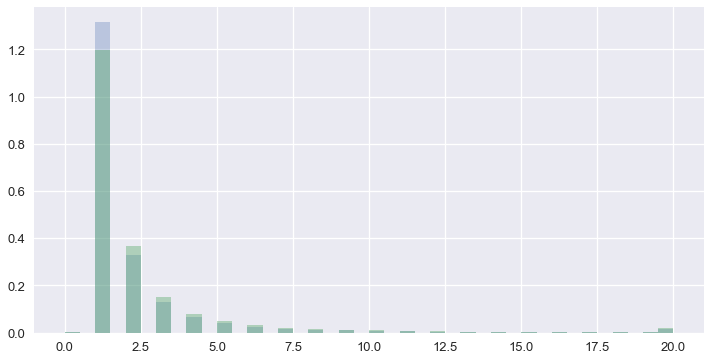

In [45]:
aggregated_data.item_cnt_day.pipe(np.clip,a_min=0,a_max=20).hist(alpha=0.3,density=1,bins=40)
(aggregated_data
 .assign(shop_item=lambda x: x.shop_id.astype(str)+"-"+x.item_id.astype(str))
 .query("shop_item in @test_combis")
 .item_cnt_day.pipe(np.clip,a_min=0,a_max=20).hist(alpha=0.4,density=1,bins=40)
)

In [25]:
(aggregated_data
 .assign(shop_item=lambda x: x.shop_id.astype(str)+"-"+x.item_id.astype(str))
 .query("shop_item in @test_combis")
 .item_cnt_day.pipe(np.clip,a_min=0,a_max=20).describe()
)

count   600159.000
mean         2.278
std          2.911
min          0.000
25%          1.000
50%          1.000
75%          2.000
max         20.000
Name: item_cnt_day, dtype: float64

In [26]:
aggregated_data.item_cnt_day.pipe(np.clip,a_min=0,a_max=20).describe()

count   1609124.000
mean          2.023
std           2.578
min           0.000
25%           1.000
50%           1.000
75%           2.000
max          20.000
Name: item_cnt_day, dtype: float64

In [63]:
preX=(aggregated_data
.assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+1).astype(int))
 .merge(items.drop(columns="item_name"),how="left")
 
 .merge(item_price,how="left")
 .merge(shop_price,how="left")
 
 .merge(item_price_cat,how="left")
 .merge(shop_price_cat,how="left")
 
 .merge(item_sold,how="left")
 .merge(shop_sold,how="left")
 .merge(cat_sold,how="left")
 .merge(shop_cat_sold,how="left")


)
past_month=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+1)
 .query("date_block_num>=0")
 .rename(columns={"item_cnt_day":"prev_month_value1"})
)

past_month2=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+2)
 .rename(columns={"item_cnt_day":"prev_month_value2"})
)

past_month3=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+3)
 .rename(columns={"item_cnt_day":"prev_month_value3"})
)

past_month4=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+4)
 .rename(columns={"item_cnt_day":"prev_month_value4"})
)

past_month5=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+5)
 .rename(columns={"item_cnt_day":"prev_month_value5"})
)

past_month6=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+6)
 .rename(columns={"item_cnt_day":"prev_month_value6"})
)


past=["prev_month_value"+str(i) for i in range(1,7)]
preX2=(preX
       .merge(past_month,how="left")
       .merge(past_month2,how="left")
       .merge(past_month3,how="left")
       .merge(past_month4,how="left")
       .merge(past_month5,how="left")
       .merge(past_month6,how="left")

       
      # .drop(columns=["shop_id","item_id","item_category_id"])
      )
preX2[past]=preX2[past].fillna(0)

preX2=preX2.sample(frac=1,replace=False)

In [64]:
preX2[["shop_id","item_id","item_category_id"]]= \
preX2[["shop_id","item_id","item_category_id"]].apply(pd.Categorical,axis=0)


In [65]:
#Drop combinations that are not in the set of the combinations of the last 6 months
recent="date_block_num>=(33-6)"
recent_not="date_block_num<(33-6)"
shops_drop=preX2.query(recent).shop_id.astype(int).unique()
items_drop=preX2.query(recent).item_id.astype(int).unique()

shops_drop_old=preX2.query(recent_not).shop_id.astype(int).unique()
items_drop_old=preX2.query(recent_not).item_id.astype(int).unique()

In [66]:
preX2=preX2.query("shop_id in @shops_drop").copy()

In [67]:
preX2.drop(columns=["item_id","shop_id","item_category_id"],inplace=True)

In [68]:
validation="(year==3 and month in [10])"

X_val = preX2.query(validation).drop(
    columns=["item_cnt_day","date_block_num","year","month"])
y_val = preX2.query(validation).item_cnt_day.pipe(
    np.clip, a_max=20, a_min=0)

training="not "+validation
X_train = preX2.query(training).drop(
    columns=["item_cnt_day","date_block_num","year","month"])
y_train = preX2.query(training).item_cnt_day.pipe(
    np.clip, a_max=20, a_min=0)
X_train.loc[:,X_train.dtypes=="float64"]=X_train.loc[:,X_train.dtypes=="float64"].astype(np.float32)
X_val.loc[:,X_val.dtypes=="float64"]=X_val.loc[:,X_val.dtypes=="float64"].astype(np.float32)

In [69]:
print(X_train.shape)
print(X_val.shape)

(1474537, 31)
(31531, 31)


In [70]:
preX2[["prev_month_value1","item_cnt_day","prev_month_value2","prev_month_value3",
      "prev_month_value4","prev_month_value5"]].corr()

,prev_month_value1,item_cnt_day,prev_month_value2,prev_month_value3,prev_month_value4,prev_month_value5
prev_month_value1,1.000,0.526,0.570,0.417,0.345,0.300
item_cnt_day,0.526,1.000,0.368,0.301,0.261,0.239
prev_month_value2,0.570,0.368,1.000,0.595,0.444,0.371
prev_month_value3,0.417,0.301,0.595,1.000,0.613,0.466
prev_month_value4,0.345,0.261,0.444,0.613,1.000,0.626
prev_month_value5,0.300,0.239,0.371,0.466,0.626,1.000


## LightGBM

In [ ]:
# train_data=lgb.Dataset(X_train,y_train)
# val_data=lgb.Dataset(X_val,y_val)


In [ ]:
# param = {'num_leaves': 64,
#              'objective': 'regression',
#             "metric":["l2_root"],
#             "learning_rate":0.001,
#             "max_depth":-1,
#             "seed":12,
#          "max_bin":1024
# }

# gbm = lgb.train(param, train_data,num_boost_round=10000, valid_sets=[val_data],
#                     early_stopping_rounds=100,verbose_eval=100)


In [ ]:
# pd.DataFrame({"cols":gbm.feature_name(),"im":gbm.feature_importance()})

In [ ]:
# y_pred=np.clip(gbm.predict(X_train, num_iteration=gbm.best_iteration),a_max=20,a_min=0)
# print('The rmse of prediction is:', mean_squared_error(y_train,y_pred) ** 0.5)
# print('The r2 is:',r2_score(y_train, y_pred))

# y_pred=np.clip(gbm.predict(X_val, num_iteration=gbm.best_iteration),a_max=20,a_min=0)

# print('The rmse of prediction is:', mean_squared_error(y_val,y_pred) ** 0.5)
# print('The r2 is:',r2_score(y_val, y_pred))

## XGBoost

In [55]:
from xgboost import XGBRegressor
import xgboost
xgb =  XGBRegressor(nthread=4,n_estimators=20,
                    learning_rate=0.05,
                    base_score=2,max_depth=7,
                    gamma=0,
                    subsample=0.75,
                    colsample_bytree=1
                  )

In [56]:
xgb.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=True,
       eval_metric="rmse",early_stopping_rounds=50)

[0]	validation_0-rmse:2.49839
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.44829
[2]	validation_0-rmse:2.40061
[3]	validation_0-rmse:2.36818


KeyboardInterrupt: 

In [ ]:
plt.plot(xgb.evals_result_["validation_0"]["rmse"])

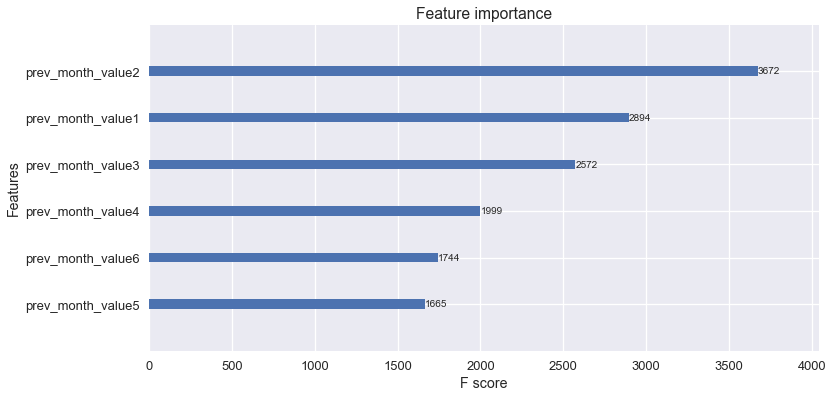

In [123]:
plt.figure(figsize=(12,6))
xgboost.plot_importance(xgb,ax=plt.gca())

In [124]:
y_pred=np.clip(xgb.predict(X_train, ntree_limit=xgb.best_ntree_limit),a_max=20,a_min=0)
print('The rmse of prediction is:', mean_squared_error(y_train,y_pred) ** 0.5)
print('The r2 is:',r2_score(y_train, y_pred))

y_pred=np.clip(xgb.predict(X_val, ntree_limit=xgb.best_ntree_limit),a_max=20,a_min=0)

print('The rmse of prediction is:', mean_squared_error(y_val,y_pred) ** 0.5)
print('The r2 is:',r2_score(y_val, y_pred))

The rmse of prediction is: 2.10544184014
The r2 is: 0.344946361224
The rmse of prediction is: 2.19339898366
The r2 is: 0.253060750172


In [88]:
X_train_clean=X_train.apply(lambda x: x.fillna(x.mean()),axis=0).drop(columns=["mean_sold_shop","std_sold_shop"])
y_train_clean=y_train[X_train_clean.index]

In [ ]:
from sklearn.neighbors  import KNeighborsRegressor as learner
regr = learner(n_jobs=4)
regr.fit(X_train_clean,y_train_clean)

In [ ]:
regr.score(X_train_clean,y_train_clean)

In [96]:
#Retrain on full set

X = pd.concat([X_train,X_val])
y = pd.concat([y_train,y_val])
#xgb =  XGBRegressor(nthread=4,n_estimators=20,learning_rate=0.1,base_score=0,max_depth=10
                  
#xgb.fit(X,y,verbose=True,  eval_metric="rmse")

In [105]:
X_clean=X.apply(lambda x: x.fillna(x.mean()),axis=0).drop(columns=["mean_sold_shop","std_sold_shop"])


In [112]:
regr.fit(X_clean,y,warm_start=True,n_iter=10)

TypeError: fit() got an unexpected keyword argument 'warm_start'

In [111]:
regr.score(X_clean,y)

0.44458616742404727

In [ ]:
y_pred=np.clip(gbm.predict(X_train, num_iteration=gbm.best_iteration),a_max=20,a_min=0)
print('The rmse of prediction is:', mean_squared_error(y_train,y_pred) ** 0.5)
print('The r2 is:',r2_score(y_train, y_pred))

y_pred=np.clip(gbm.predict(X_val, num_iteration=gbm.best_iteration),a_max=20,a_min=0)

print('The rmse of prediction is:', mean_squared_error(y_val,y_pred) ** 0.5)
print('The r2 is:',r2_score(y_val, y_pred))

y_pred=np.clip(gbm.predict(X, num_iteration=gbm.best_iteration),a_max=20,a_min=0)

print('The rmse of prediction is:', mean_squared_error(y,y_pred) ** 0.5)
print('The r2 is:',r2_score(y, y_pred))

## Predict for training set

In [27]:
X_test=(test
.assign(date_block_num=34,month=11,year=3)
.merge(items.drop(columns="item_name"),how="left")
  .merge(item_price,how="left")
 .merge(shop_price,how="left")
 
 .merge(item_price_cat,how="left")
 .merge(shop_price_cat,how="left")
 
 .merge(item_sold,how="left")
 .merge(shop_sold,how="left")
 .merge(cat_sold,how="left")
 .merge(shop_cat_sold,how="left")
 #.drop(columns=["shop_id","item_id","item_category_id"]) 
).drop(columns="ID")

past_month=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+1)
 .rename(columns={"item_cnt_day":"prev_month_value1"})
)

past_month2=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+2)
 .rename(columns={"item_cnt_day":"prev_month_value2"})
)

past_month3=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+3)
 .rename(columns={"item_cnt_day":"prev_month_value3"})
)

past_month4=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+4)
 .rename(columns={"item_cnt_day":"prev_month_value4"})
)

past_month5=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+5)
 .rename(columns={"item_cnt_day":"prev_month_value5"})
)

past_month6=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+6)
 .rename(columns={"item_cnt_day":"prev_month_value6"})
)



past=["prev_month_value"+str(i) for i in range(1,7)]
preX2=(X_test
       .merge(past_month,how="left")
       .merge(past_month2,how="left")
       .merge(past_month3,how="left")
       .merge(past_month4,how="left")
       .merge(past_month5,how="left")
       .merge(past_month6,how="left")

       
     #  .drop(columns=["shop_id","item_id","item_category_id"])
      )
preX2[past]=preX2[past].fillna(0)
preX2[["shop_id","item_id","item_category_id"]]= \
preX2[["shop_id","item_id","item_category_id"]].apply(pd.Categorical,axis=0)

preX2.drop(columns=["year","date_block_num"],inplace=True)
preX2.loc[:,preX2.dtypes=="float64"]=preX2.loc[:,preX2.dtypes=="float64"].astype(np.float32)

NameError: name 'item_price' is not defined

In [ ]:
y_test=np.clip(xgb.predict(preX2.drop(columns=["item_id","shop_id","item_category_id"])),a_min=0,a_max=20)

In [ ]:

y_test[preX2.query("((item_id in @items_drop_old) and (shop_id in @shops_drop_old))").index]=0

In [ ]:
plt.figure(figsize=(24,12))
plt.hist(y_val,density=1,alpha=0.5,label="validation",bins=40)
plt.hist(y_train,density=1,alpha=0.5,label="train",bins=40)
#plt.hist(y_test,alpha=0.5,density=1,label="predicted",bins=20)
plt.hist(y_test,alpha=0.5,density=1,label="predicted",bins=40,color="red")
plt.legend()


In [ ]:
results=pd.DataFrame({"ID":test.ID,"item_cnt_month":y_test})
results.to_csv("lightgbm_categorical_filtered2.csv",index=False)